In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from palettable.colorbrewer.diverging import RdYlBu_11_r

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45979/status,
Dashboard: /proxy/45979/status,Workers: 4
Total threads: 8,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41657,Workers: 4
Dashboard: /proxy/45979/status,Total threads: 8
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:35781,Total threads: 2
Dashboard: /proxy/41381/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:44265,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')
mask = mask['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu']
hu = hu.sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90,-50.1,.1))), 1, np.nan)
land_ice_mask = land_ice_mask.interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, 
                                     land_ice_mask['lon'] + 360, 
                                     land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon':'_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj':sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj':'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_lin = xr.open_dataset('../data/smooth_div_line.nc')
div_lin = div_lin['__xarray_dataarray_variable__']

Load reanalysis and CMIP6 multimodel mean

In [4]:
uas = {}
vas = {}
psl = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas']
    uas[k] = uas[k].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas']
    vas[k] = vas[k].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc')['psl']
    psl[k] = psl[k].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')

In [5]:
wsp = {}
for k in keys:
    wsp[k] = np.sqrt(uas[k]**2 + vas[k]**2)

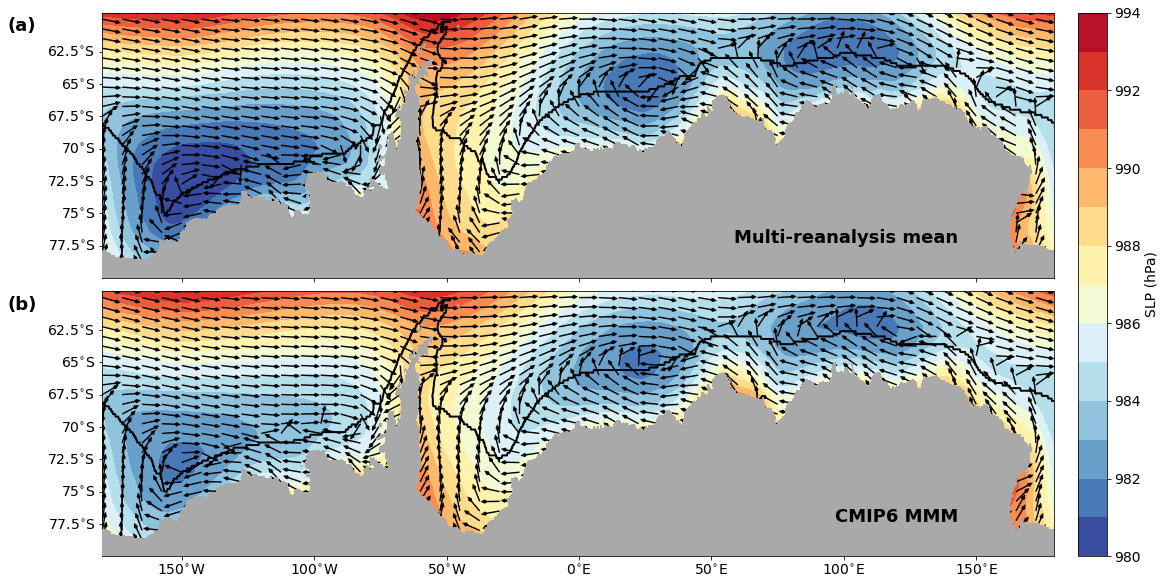

In [21]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 10))
gr = gs.GridSpec(2, 2, figure = fig, width_ratios = [1,.03],
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]), fig.add_subplot(gr[:2,1])]
for ax, label in zip(axs, ['(a)', '(b)']):
    ax.text(-0.1, .93, label, transform = ax.transAxes, size = 18, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 3)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)

axs[0].text(0.9, .13, 'Multi-reanalysis mean', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.9, .13, 'CMIP6 MMM', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')
# Reanalysis
k = 'reanalysis'
c = axs[0].contourf(psl[k]['lon'], psl[k]['lat'], psl[k]/100,
                   levels = np.arange(980, 995, 1), cmap = RdYlBu_11_r.mpl_colormap, 
                   zorder = 1)
fig.colorbar(c, cax = axs[-1]).set_label('SLP (hPa)')
axs[0].quiver(uas[k]['lon'][::10].values, uas[k]['lat'][::1].values, 
              (uas[k]/wsp[k])[::1,::10].values, (vas[k]/wsp[k])[::1,::10].values, 
              scale = 50, width = 0.0015, headlength = 3, zorder = 2)
# CMIP6
k = 'cmip6'
c = axs[1].contourf(psl[k]['lon'], psl[k]['lat'], psl[k]/100,
                   levels = np.arange(980, 995, 1), cmap = RdYlBu_11_r.mpl_colormap, 
                   zorder = 1)
axs[1].quiver(uas[k]['lon'][::10].values, uas[k]['lat'][::1].values, 
              (uas[k]/wsp[k])[::1,::10].values, (vas[k]/wsp[k])[::1,::10].values, 
              scale = 50, width = 0.0015, headlength = 3, zorder = 2)

plt.savefig('../results/v6/sup_wind_direction.jpg', bbox_inches = 'tight', dpi = 800)